<a href="https://colab.research.google.com/github/user1896/Neural-Network-image-classification/blob/main/Comparing_the_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LeNet-5 vs VGG-16 vs AlexNet vs ResNet

In [1]:
from __future__ import print_function
import json
import keras
import pickle
import os.path
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import AveragePooling2D, Input
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LambdaCallback
from keras.regularizers import l2
from keras import optimizers
from keras import regularizers
from keras.utils.vis_utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Input
from keras.layers import add
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Load dataset

In [2]:
# load train and test dataset
def load_dataset():
  # load dataset
  (trainX, trainY), (testX, testY) = cifar10.load_data()
  # one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)
  return trainX, trainY, testX, testY

In [3]:
# scale pixels
def prep_pixels(train, test):
  # convert from integers to floats
  train_norm = train.astype( 'float32' )
  test_norm = test.astype( 'float32' )
  # normalize to range 0-1
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0
  # return normalized images
  return train_norm, test_norm

In [4]:
# load dataset
trainX, trainY, testX, testY = load_dataset()
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)

170498071/170498071 [==============================] - 3s 0us/step


In [5]:
n_classes = 10

# Load LeNet-5

In [6]:
# Load the model
reconstructed_LeNet = keras.models.load_model("/content/drive/MyDrive/cnn models/LeNetGC.h5")

# Compute ROC curve for LeNet

In [7]:
y_scoreLeNet = reconstructed_LeNet.predict(testX)
test_yLeNet = label_binarize(testY, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

313/313 [==============================] - 10s 29ms/step


In [8]:
# Compute ROC curve and ROC area for each class
fprLeNet = dict()
tprLeNet = dict()
roc_aucLeNet = dict()
for i in range(n_classes):
    fprLeNet[i], tprLeNet[i], _ = roc_curve(test_yLeNet[:, i], y_scoreLeNet[:, i])
    roc_aucLeNet[i] = auc(fprLeNet[i], tprLeNet[i])

# Compute micro-average ROC curve and ROC area
fprLeNet["micro"], tprLeNet["micro"], _ = roc_curve(test_yLeNet.ravel(), y_scoreLeNet.ravel())
roc_aucLeNet["micro"] = auc(fprLeNet["micro"], tprLeNet["micro"])

lw = 2
# First aggregate all false positive rates
all_fprLeNet = np.unique(np.concatenate([fprLeNet[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tprLeNet = np.zeros_like(all_fprLeNet)
for i in range(n_classes):
    mean_tprLeNet += interp(all_fprLeNet, fprLeNet[i], tprLeNet[i])

# Finally average it and compute AUC
mean_tprLeNet /= n_classes

fprLeNet["macro"] = all_fprLeNet
tprLeNet["macro"] = mean_tprLeNet
roc_aucLeNet["macro"] = auc(fprLeNet["macro"], tprLeNet["macro"])

<ipython-input-8-206b7f1e4f2b>:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tprLeNet += interp(all_fprLeNet, fprLeNet[i], tprLeNet[i])


# LeNet ROC curve for each class

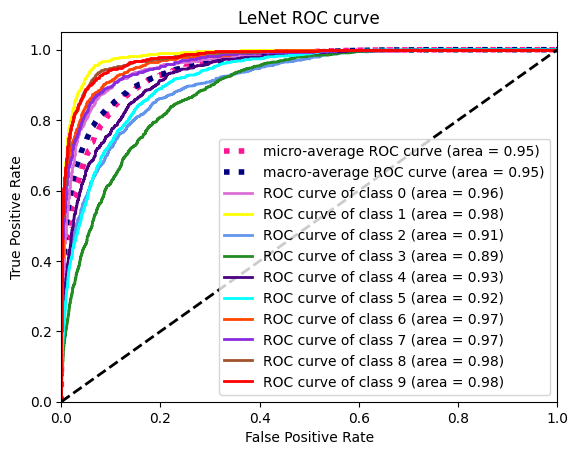

In [9]:
# Plot all ROC curves
plt.figure()
plt.plot(fprLeNet["micro"], tprLeNet["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_aucLeNet["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

plt.plot(fprLeNet["macro"], tprLeNet["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_aucLeNet["macro"]),
          color='navy', linestyle=':', linewidth=4)

colors = cycle(['Orchid', 'Yellow', 'cornflowerblue', 'ForestGreen', 'Indigo','Cyan', 'OrangeRed', 'BlueViolet', 'Sienna', 'Red'])
for i, color in zip(range(10), colors):
    plt.plot(fprLeNet[i], tprLeNet[i], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i, roc_aucLeNet[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LeNet ROC curve')
plt.legend(loc="lower right")
plt.show()

# Load VGG-16

In [10]:
# Load the model
reconstructed_VGG = keras.models.load_model("/content/drive/MyDrive/cnn models/VggGC.h5")

# Compute ROC curve for VGG

In [11]:
y_scoreVGG = reconstructed_VGG.predict(testX)
test_yVGG = label_binarize(testY, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

313/313 [==============================] - 157s 501ms/step


In [12]:
# Compute ROC curve and ROC area for each class
fprVGG = dict()
tprVGG = dict()
roc_aucVGG = dict()
for i in range(n_classes):
    fprVGG[i], tprVGG[i], _ = roc_curve(test_yVGG[:, i], y_scoreVGG[:, i])
    roc_aucVGG[i] = auc(fprVGG[i], tprVGG[i])

# Compute micro-average ROC curve and ROC area
fprVGG["micro"], tprVGG["micro"], _ = roc_curve(test_yVGG.ravel(), y_scoreVGG.ravel())
roc_aucVGG["micro"] = auc(fprVGG["micro"], tprVGG["micro"])

lw = 2
# First aggregate all false positive rates
all_fprVGG = np.unique(np.concatenate([fprVGG[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tprVGG = np.zeros_like(all_fprVGG)
for i in range(n_classes):
    mean_tprVGG += interp(all_fprVGG, fprVGG[i], tprVGG[i])

# Finally average it and compute AUC
mean_tprVGG /= n_classes

fprVGG["macro"] = all_fprVGG
tprVGG["macro"] = mean_tprVGG
roc_aucVGG["macro"] = auc(fprVGG["macro"], tprVGG["macro"])

<ipython-input-12-73edf342af75>:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tprVGG += interp(all_fprVGG, fprVGG[i], tprVGG[i])


# VGG ROC curve for each class

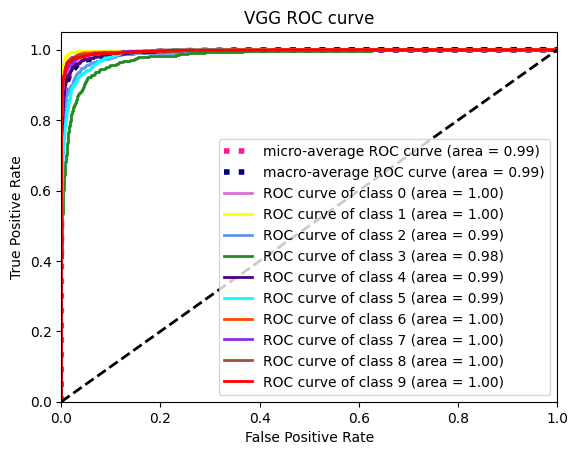

In [13]:
# Plot all ROC curves
plt.figure()
plt.plot(fprVGG["micro"], tprVGG["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_aucVGG["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

plt.plot(fprVGG["macro"], tprVGG["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_aucVGG["macro"]),
          color='navy', linestyle=':', linewidth=4)

colors = cycle(['Orchid', 'Yellow', 'cornflowerblue', 'ForestGreen', 'Indigo','Cyan', 'OrangeRed', 'BlueViolet', 'Sienna', 'Red'])
for i, color in zip(range(10), colors):
    plt.plot(fprVGG[i], tprVGG[i], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i, roc_aucVGG[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('VGG ROC curve')
plt.legend(loc="lower right")
plt.show()

# Load AlexNet

In [14]:
# Load the model
reconstructed_AlexNet = keras.models.load_model("/content/drive/MyDrive/cnn models/AlexNetGC.h5")

# Compute ROC curve for AlexNet

In [15]:
y_scoreAlexNet = reconstructed_AlexNet.predict(testX)
test_yAlexNet = label_binarize(testY, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

313/313 [==============================] - 31s 98ms/step


In [16]:
# Compute ROC curve and ROC area for each class
fprAlexNet = dict()
tprAlexNet = dict()
roc_aucAlexNet = dict()
for i in range(n_classes):
    fprAlexNet[i], tprAlexNet[i], _ = roc_curve(test_yAlexNet[:, i], y_scoreAlexNet[:, i])
    roc_aucAlexNet[i] = auc(fprAlexNet[i], tprAlexNet[i])

# Compute micro-average ROC curve and ROC area
fprAlexNet["micro"], tprAlexNet["micro"], _ = roc_curve(test_yAlexNet.ravel(), y_scoreAlexNet.ravel())
roc_aucAlexNet["micro"] = auc(fprAlexNet["micro"], tprAlexNet["micro"])

lw = 2
# First aggregate all false positive rates
all_fprAlexNet = np.unique(np.concatenate([fprAlexNet[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tprAlexNet = np.zeros_like(all_fprAlexNet)
for i in range(n_classes):
    mean_tprAlexNet += interp(all_fprAlexNet, fprAlexNet[i], tprAlexNet[i])

# Finally average it and compute AUC
mean_tprAlexNet /= n_classes

fprAlexNet["macro"] = all_fprAlexNet
tprAlexNet["macro"] = mean_tprAlexNet
roc_aucAlexNet["macro"] = auc(fprAlexNet["macro"], tprAlexNet["macro"])

<ipython-input-16-2f25ba437e6c>:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tprAlexNet += interp(all_fprAlexNet, fprAlexNet[i], tprAlexNet[i])


# AlexNet ROC curve for each class

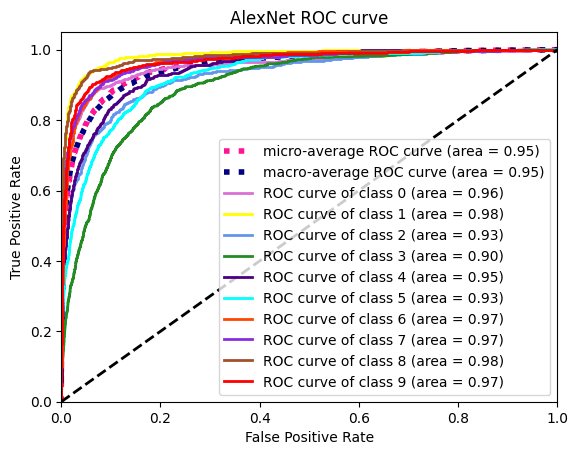

In [17]:
# Plot all ROC curves
plt.figure()
plt.plot(fprAlexNet["micro"], tprAlexNet["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_aucAlexNet["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

plt.plot(fprAlexNet["macro"], tprAlexNet["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_aucAlexNet["macro"]),
          color='navy', linestyle=':', linewidth=4)

colors = cycle(['Orchid', 'Yellow', 'cornflowerblue', 'ForestGreen', 'Indigo','Cyan', 'OrangeRed', 'BlueViolet', 'Sienna', 'Red'])
for i, color in zip(range(10), colors):
    plt.plot(fprAlexNet[i], tprAlexNet[i], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i, roc_aucAlexNet[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AlexNet ROC curve')
plt.legend(loc="lower right")
plt.show()

# Load ResNet

In [18]:
# Load the model
reconstructed_ResNet = keras.models.load_model("/content/drive/MyDrive/cnn models/ResNetGC.h5")

# Compute ROC curve for ResNet

In [19]:
y_scoreResNet = reconstructed_ResNet.predict(testX)
test_yResNet = label_binarize(testY, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

313/313 [==============================] - 80s 253ms/step


In [20]:
# Compute ROC curve and ROC area for each class
fprResNet = dict()
tprResNet = dict()
roc_aucResNet = dict()
for i in range(n_classes):
    fprResNet[i], tprResNet[i], _ = roc_curve(test_yResNet[:, i], y_scoreResNet[:, i])
    roc_aucResNet[i] = auc(fprResNet[i], tprResNet[i])

# Compute micro-average ROC curve and ROC area
fprResNet["micro"], tprResNet["micro"], _ = roc_curve(test_yResNet.ravel(), y_scoreResNet.ravel())
roc_aucResNet["micro"] = auc(fprResNet["micro"], tprResNet["micro"])

lw = 2
# First aggregate all false positive rates
all_fprResNet = np.unique(np.concatenate([fprResNet[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tprResNet = np.zeros_like(all_fprResNet)
for i in range(n_classes):
    mean_tprResNet += interp(all_fprResNet, fprResNet[i], tprResNet[i])

# Finally average it and compute AUC
mean_tprResNet /= n_classes

fprResNet["macro"] = all_fprResNet
tprResNet["macro"] = mean_tprResNet
roc_aucResNet["macro"] = auc(fprResNet["macro"], tprResNet["macro"])

<ipython-input-20-5c636a462b1c>:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tprResNet += interp(all_fprResNet, fprResNet[i], tprResNet[i])


# ResNet ROC curve for each class

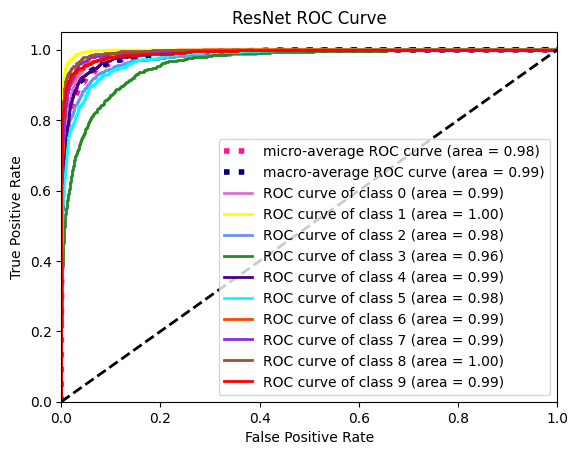

In [21]:
# Plot all ROC curves
plt.figure()
plt.plot(fprResNet["micro"], tprResNet["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_aucResNet["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

plt.plot(fprResNet["macro"], tprResNet["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_aucResNet["macro"]),
          color='navy', linestyle=':', linewidth=4)

colors = cycle(['Orchid', 'Yellow', 'cornflowerblue', 'ForestGreen', 'Indigo','Cyan', 'OrangeRed', 'BlueViolet', 'Sienna', 'Red'])
for i, color in zip(range(10), colors):
    plt.plot(fprResNet[i], tprResNet[i], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i, roc_aucResNet[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ResNet ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Comparison of the average ROC curve of each model

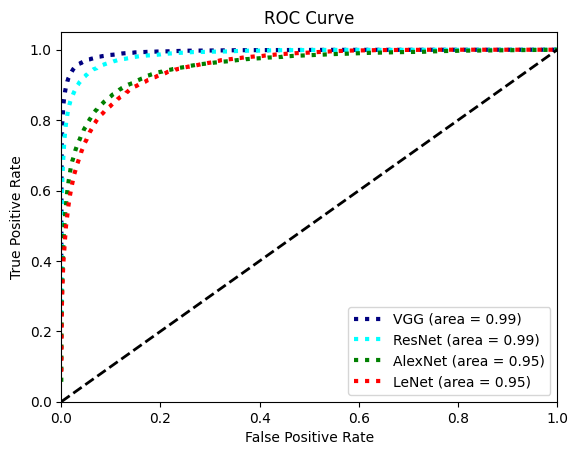

In [22]:
# Plot all ROC curves
plt.figure()

plt.plot(fprVGG["macro"], tprVGG["macro"],
          label='VGG (area = {0:0.2f})'
                ''.format(roc_aucVGG["macro"]),
          color='navy', linestyle=':', linewidth=3)

plt.plot(fprResNet["macro"], tprResNet["macro"],
          label='ResNet (area = {0:0.2f})'
                ''.format(roc_aucResNet["macro"]),
          color='Cyan', linestyle=':', linewidth=3)

plt.plot(fprAlexNet["macro"], tprAlexNet["macro"],
          label='AlexNet (area = {0:0.2f})'
                ''.format(roc_aucAlexNet["macro"]),
          color='green', linestyle=':', linewidth=3)

plt.plot(fprLeNet["macro"], tprLeNet["macro"],
          label='LeNet (area = {0:0.2f})'
                ''.format(roc_aucLeNet["macro"]),
          color='red', linestyle=':', linewidth=3)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()